# Meme Humour Classification: Deep-learning-based Multi-modal Fusion with Humor Semantics

## 1. import

In [3]:
import os
import sys

# TODO: change this to the path to your homework folder
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive')
print(os.listdir(GOOGLE_DRIVE_PATH))

os.chdir(GOOGLE_DRIVE_PATH)

['4', 'Colab Notebooks', 'df_test_pickle', 'df_train_pickle', 'df_val_pickle', 'image', 'text_embedding.py', 'result.pt', 'text', 'val_embedding_VGG_finetuned.pt', 'image_embedding_VGG_finetuned_enhanced.pt', 'test_gold.csv', 'test_embedding_VGG_finetuned.pt', 'text_embed_1.pt', 'text_embed.pt', 'test.pt', '.ipynb_checkpoints', 'meme.ipynb']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.4 MB/s eta 0:00:00


In [7]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

# import directories
import image
from text import text_embedding

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 2. Load dataset

In [17]:
# load labels_pd_pickle
train = pd.read_pickle('df_train_pickle')
val = pd.read_pickle('df_val_pickle')
test = pd.read_pickle('df_test_pickle')
# show first 5 rows
val['sarcastic']

0          little_sarcastic
1          little_sarcastic
2             not_sarcastic
3            very_sarcastic
4             not_sarcastic
               ...         
1495       little_sarcastic
1496       little_sarcastic
1497    extremely_sarcastic
1498       little_sarcastic
1499          not_sarcastic
Name: sarcastic, Length: 1500, dtype: object

In [9]:
def basic_collate_fn_all(batch):
    """Collate function for basic setting."""
    # texts
    text = torch.stack(tuple(item['text'] for item in batch)).to('cuda')
    # image
    image = torch.stack(tuple(item['image_embedding'] for item in batch)).to('cuda')
    # labels
    labels = [item['rating'] for item in batch]
    return text, image, labels

In [10]:
train_data = text_embedding.dataloader(train,'image_embedding_VGG_finetuned_enhanced.pt','text_embed_1.pt')
val_data = text_embedding.dataloader(val,'val_embedding_VGG_finetuned.pt','text_embed.pt')

In [45]:
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
train_loader = DataLoader(train_data,sampler=ImbalancedDatasetSampler(train_data), batch_size=32, collate_fn=basic_collate_fn_all, shuffle=True)
dev_loader = DataLoader(val_data,sampler=ImbalancedDatasetSampler(val_data), batch_size=32, collate_fn=basic_collate_fn_all, shuffle=True)

TypeError: ignored

# 3. CLIP Embedding

## 4. Train Model

In [114]:
# transformer for multi-tasking

import torch
import torch.nn as nn
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(TransformerClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        
        self.fc2 = nn.Linear(800, 512)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(512,nhead=8),2
        )
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(512,5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x,y):
        # res = self.encoder(y)
        x = self.fc1(self.sigmoid(x.squeeze()))
        y = self.fc2(self.sigmoid(y))
        dot_prod = torch.zeros(x.shape).to('cuda')
        for idx in range(x.shape[0]):
            dot_prod[idx] = torch.dot(x[idx],y[idx])
        x = self.encoder(torch.stack((x,)))
        x = x.max(dim = 0)[0]
        x = self.dropout(x)
        res = self.fc3(x)
        return res


In [90]:
def train_tf(model, train_loader, optimizer, epochs=5):
    train_loss, train_loss_ind, val_loss, val_loss_ind = [], [], [], []
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for idx, (text, image, target) in enumerate(train_loader):
            optimizer.zero_grad()
            target = torch.Tensor(target).to('cuda')
            output = model(text,image).squeeze()
            loss = nn.L1Loss()(output,target)
            loss.backward()
            optimizer.step()
        if epoch%1 == 0:
          print('Epoch: {} Loss: {}'.format(
                    epoch, 
                    loss.item()))
        train_loss_ind.append(epoch)
        val_loss_ind.append(epoch)
        train_loss.append(loss.item())
        model.eval()
        acc = torch.Tensor([0,0,0,0,0]).to('cuda')
        with torch.no_grad():
          for idx, (text, image, target) in enumerate(dev_loader):
              target = torch.Tensor(target).to('cuda')
              output = model(text,image).squeeze()
              loss = nn.L1Loss()(output,target)
              acc += sum(torch.round(output) == target) /1500
        if epoch%1 == 0:
          print('Epoch',epoch,'val loss',loss.item(),'val acc',acc)
        val_loss.append(loss.item())
    stats = {'train_loss': train_loss,
          'train_loss_ind': train_loss_ind,
          'val_loss': val_loss,
          'val_loss_ind': val_loss_ind,
          'accuracy': acc,
    }
    return model,stats

In [14]:
import matplotlib.pyplot as plt
from torch import optim

In [15]:
def plot_loss(stats):
    """Plot training loss and validation loss."""
    plt.plot(stats['train_loss_ind'], stats['train_loss'], label='Training loss')
    plt.plot(stats['val_loss_ind'], stats['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.show()

1e-05 0 512 2
Epoch: 0 Loss: 0.5145525336265564
Epoch 0 val loss 0.40398794412612915 val acc tensor([0.4967, 0.5360, 0.7400, 0.9533, 0.8667], device='cuda:0')
Epoch: 1 Loss: 0.5014232397079468
Epoch 1 val loss 0.4240027070045471 val acc tensor([0.4967, 0.5340, 0.7400, 0.9533, 0.8667], device='cuda:0')
Epoch: 2 Loss: 0.42568492889404297
Epoch 2 val loss 0.3641502857208252 val acc tensor([0.4967, 0.5360, 0.7400, 0.9533, 0.8667], device='cuda:0')
Epoch: 3 Loss: 0.4703364670276642
Epoch 3 val loss 0.4334618151187897 val acc tensor([0.4967, 0.5213, 0.7400, 0.9533, 0.8667], device='cuda:0')
Epoch: 4 Loss: 0.5024631023406982
Epoch 4 val loss 0.37496691942214966 val acc tensor([0.4967, 0.3940, 0.7400, 0.9533, 0.8667], device='cuda:0')
Epoch: 5 Loss: 0.5106714367866516
Epoch 5 val loss 0.37547728419303894 val acc tensor([0.4967, 0.5360, 0.7400, 0.9533, 0.8667], device='cuda:0')
Epoch: 6 Loss: 0.5229639410972595
Epoch 6 val loss 0.4751802682876587 val acc tensor([0.4967, 0.5360, 0.7400, 0.9533, 

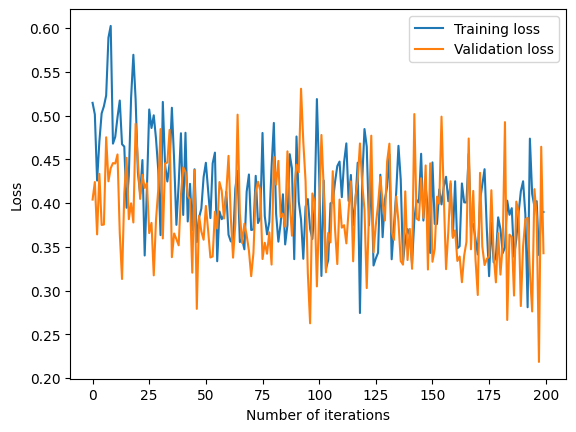

In [115]:
for lr in [0.00001]:
  for wd in [0]:
    for hd in [512]:
      for ly in [2]:
        model_tf = TransformerClassifier(hd,5,ly).to('cuda')
        optimizer = optim.Adam(model_tf.parameters(), lr=lr,weight_decay=wd)
        print(lr,wd,hd,ly)
        model, stats = train_tf(model_tf,dev_loader,optimizer,200)
        plot_loss(stats)

In [ ]:
for lr in [0.001,0.0001]:
  for wd in [0,0.00001]:
    for hd in [128,256]:
      for ly in [2,4]:
        model_tf = TransformerClassifier(hd,1,ly).to('cuda')
        optimizer = optim.AdamW(model_tf.parameters(), lr=lr,weight_decay=wd)
        print(lr,wd,hd,ly)
        model, stats = train_tf(model_tf,train_loader,optimizer,50)
        plot_loss(stats)

## 5. Test Model

In [24]:
test = pd.read_csv('test_gold.csv')
test['humour'] = test['humour'].map({'hilarious': 3, 'very_funny':2, 'funny': 1, 'not_funny': 0})
test['sarcastic'] = test['sarcastic'].map({'extremely_sarcastic':3, 'very_sarcastic': 2, 'little_sarcastic': 1, 'not_sarcastic': 0})
test['offensive'] = test['offensive'].map({'hateful_offensive':3, 'very_offensive': 2, 'slight': 1, 'not_offensive': 0})
test['motivational'] = test['motivational'].map({'motivational': 1, 'not_motivational': 0})
test['overall_sentiment'] = test['overall_sentiment'].map({'very_positive':2,'positive': 1, 'very_negative':0, 'negative': 0, 'neutral': 1})

In [ ]:
model

In [76]:
def get_test(model):
  image_embedding = torch.load('test_embedding_VGG_finetuned.pt').squeeze().to('cuda')
  text_embedding = torch.load('test.pt')
  text = torch.stack(tuple(item for item in text_embedding)).to('cuda')
  result = torch.round(model.forward(text,image_embedding)).to('cuda')
  print("Humour test:",sum(torch.Tensor(test['humour']).to('cuda')==result[:,0])/1500)
  print("Sarcastic test:",sum(torch.Tensor(test['sarcastic']).to('cuda')==result[:,1])/1500)
  print("Offensive test:",sum(torch.Tensor(test['offensive']).to('cuda')==result[:,2])/1500)
  print("Moltivational test:",sum(torch.Tensor(test['motivational']).to('cuda')==result[:,3])/1500)
  print("Overall test:",sum(torch.Tensor(test['overall_sentiment']).to('cuda')==result[:,3])/1500)

In [93]:
get_test(model)

Humour test: tensor(0.5933, device='cuda:0')
Sarcastic test: tensor(0.1240, device='cuda:0')
Offensive test: tensor(0.6280, device='cuda:0')
Moltivational test: tensor(0.9867, device='cuda:0')
Overall test: tensor(0.3007, device='cuda:0')


In [95]:
(0.5933+0.1240+0.6280+0.9867)/4

0.583